In [ ]:
# import libarries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Flatten, Dense, Dropout, LSTM, SpatialDropout1D, Bidirectional,Input,Activation

In [ ]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [ ]:
#data visualization and summary statistics
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [ ]:
#group by spam and ham
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [ ]:
# get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# For ham and spam messages, create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

In [ ]:
# # wordcloud of ham messages
# ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
#                           background_color ="black", colormap='Blues').generate(ham_msg_text)
# plt.figure(figsize=(16,10))
# plt.imshow(ham_msg_cloud, interpolation='bilinear')
# plt.axis('off') # turn off axis
# plt.show()

In [ ]:
# # wordcloud of spam messages
# spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
#                           background_color ="black", colormap='Blues').generate(spam_msg_text)
# plt.figure(figsize=(16,10))
# plt.imshow(spam_msg_cloud, interpolation='bilinear')
# plt.axis('off') # turn off axis
# plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of ham and spam email messages')

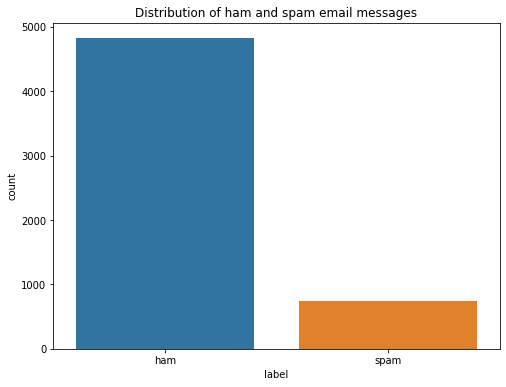

In [ ]:
# There is imbalance in spam and ham messages since there are around 4800 ham messages and 700 spam messages
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
plt.title('Distribution of ham and spam email messages')

In [ ]:
# Percentage of spam messages
(len(spam_msg)/(len(ham_msg)+len(spam_msg)))*100

13.406317300789663

In [ ]:
# one way to fix it is to downsample the ham messages equal to the spam message size
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 111)
spam_msg_df = spam_msg

In [ ]:
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


In [ ]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
msg_df.head()

,label,message
0,ham,"Short But Cute : "" Be a good person , but dont..."
1,ham,"Storming msg: Wen u lift d phne, u say ""HELLO""..."
2,ham,"Yes, princess. Are you going to make me moan?"
3,ham,Ard 530 like dat lor. We juz meet in mrt stati...
4,ham,I'm hungry buy smth home...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

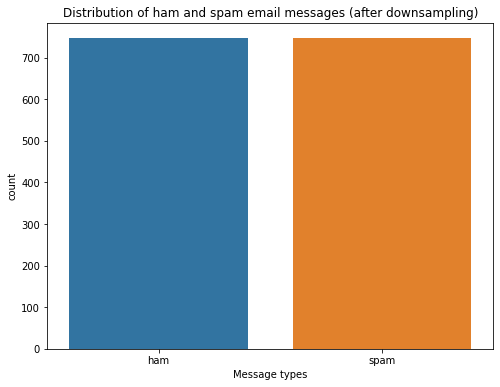

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [ ]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
print(msg_df.head())
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels


  label                                            message  text_length
0   ham  Short But Cute : " Be a good person , but dont...           78
1   ham  Storming msg: Wen u lift d phne, u say "HELLO"...          324
2   ham      Yes, princess. Are you going to make me moan?           45
3   ham  Ard 530 like dat lor. We juz meet in mrt stati...           76
4   ham                        I'm hungry buy smth home...           27


,text_length
label,
ham,71.697456
spam,138.670683


In [ ]:
# Convert the label to numeric (ham = 0 and spam = 1) and split the data into training and testing sets in the ratio 80/20

msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
msg_label

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
# Split message data and labels into train and test sets
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=123)
print(train_msg.shape, train_labels.shape, test_msg.shape, test_labels.shape)

(1195,) (1195,) (299,) (299,)


In [ ]:
#Tokenization
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it indicates we are only going to look at first 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 1500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
{k: word_index[k] for k in list(word_index)[:10]}

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10}

In [ ]:
# check how many unique tokens
tot_words = len(word_index)
tot_words

4211

In [ ]:

# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

In [ ]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)
print(train_labels.shape)
print(test_labels.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)
(1195,)
(299,)


In [ ]:
# Before padding : first sequence is 7 character long where as second one is 5
len(training_sequences[0]), len(training_sequences[1])

(7, 5)

In [ ]:
# Padded to same length of 50
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [ ]:
# As can be seen from below, the padded sequence is 50 words long. 
print(training_padded[0])

[ 99  44 997  54  33 190  42   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
#Train the Model w/ Dense Spam Detection Architechture

vocab_size = 1500 # Number of words you want to tokenize i.e maximum number of words to keep
embedding_dim = 32
drop_value = 0.2 # dropout
n_dense = 24

In [ ]:
#Dense sentiment model architecture
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            48000     
                                                                 
 global_average_pooling1d_2   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 24)                792       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 48,817
Trainable params: 48,817
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [ ]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6861 - accuracy: 0.6184 - val_loss: 0.6736 - val_accuracy: 0.6856 - 934ms/epoch - 25ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6539 - accuracy: 0.8243 - val_loss: 0.6212 - val_accuracy: 0.8930 - 121ms/epoch - 3ms/step
Epoch 3/30
38/38 - 0s - loss: 0.5771 - accuracy: 0.8895 - val_loss: 0.5137 - val_accuracy: 0.9130 - 121ms/epoch - 3ms/step
Epoch 4/30
38/38 - 0s - loss: 0.4526 - accuracy: 0.9054 - val_loss: 0.3705 - val_accuracy: 0.9331 - 111ms/epoch - 3ms/step
Epoch 5/30
38/38 - 0s - loss: 0.3132 - accuracy: 0.9297 - val_loss: 0.2529 - val_accuracy: 0.9431 - 113ms/epoch - 3ms/step
Epoch 6/30
38/38 - 0s - loss: 0.2244 - accuracy: 0.9414 - val_loss: 0.1887 - val_accuracy: 0.9498 - 124ms/epoch - 3ms/step
Epoch 7/30
38/38 - 0s - loss: 0.1675 - accuracy: 0.9607 - val_loss: 0.1498 - val_accuracy: 0.9632 - 111ms/epoch - 3ms/step
Epoch 8/30
38/38 - 0s - loss: 0.1342 - accuracy: 0.9649 - val_loss: 0.1297 - val_accuracy: 0.9666 - 117ms/epoch - 3ms/step
Epoch 9/30
38/3

In [ ]:
# Evaluate the model on test data
loss,accuracy = model.evaluate(testing_padded, test_labels)

print("Model performermance on test data is about {} accuracy with validation loss of {}" .format(loss, accuracy*100))


10/10 [==============================] - 0s 2ms/step - loss: 0.0846 - accuracy: 0.9699
Model performermance on test data is about 0.08460184931755066 accuracy with validation loss of 96.98996543884277


In [ ]:
metrics = pd.DataFrame(history.history)
metrics[25:]

,loss,accuracy,val_loss,val_accuracy
25,0.025179,0.994979,0.090165,0.973244
26,0.024066,0.994979,0.083381,0.969900
27,0.022527,0.994979,0.086421,0.969900
28,0.021717,0.994979,0.092022,0.973244
29,0.018620,0.995816,0.084602,0.969900


In [ ]:
# Rename columns of DF with  accuracy data
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[25:]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
25,0.025179,0.994979,0.090165,0.973244
26,0.024066,0.994979,0.083381,0.969900
27,0.022527,0.994979,0.086421,0.969900
28,0.021717,0.994979,0.092022,0.973244
29,0.018620,0.995816,0.084602,0.969900


In [ ]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

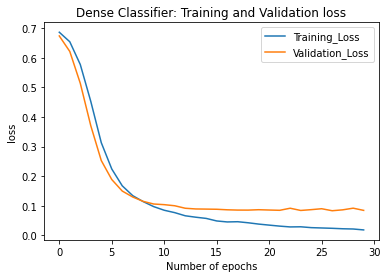

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

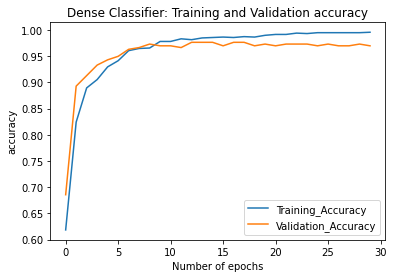

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
#LSTM layer arcitecture hyperparameters
n_lstm = 20
drop_lstm =0.2

In [226]:
#LSTM Spam detection architecture
# model1 = Sequential()
# model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
# model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
# model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
# model1.add(Dense(1, activation='sigmoid'))
# model1.add(Flatten())
def lstm():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(vocab_size,embedding_dim,input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.2)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model
model1 = lstm()
model1.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 50)]              0         
                                                                 
 embedding_27 (Embedding)    (None, 50, 32)            48000     
                                                                 
 lstm_26 (LSTM)              (None, 64)                24832     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_41 (Activation)  (None, 256)               0         
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257

In [227]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [228]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 3)
history1 = model1.fit(training_padded, train_labels, validation_split =0.2,
                     epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
30/30 - 5s - loss: 0.6938 - accuracy: 0.4833 - val_loss: 0.6927 - val_accuracy: 0.5063 - 5s/epoch - 153ms/step
Epoch 2/30
30/30 - 1s - loss: 0.5683 - accuracy: 0.6851 - val_loss: 0.2126 - val_accuracy: 0.9414 - 1s/epoch - 34ms/step
Epoch 3/30
30/30 - 1s - loss: 0.2424 - accuracy: 0.9310 - val_loss: 0.1912 - val_accuracy: 0.9456 - 1s/epoch - 35ms/step
Epoch 4/30
30/30 - 1s - loss: 0.1389 - accuracy: 0.9644 - val_loss: 0.1840 - val_accuracy: 0.9498 - 1s/epoch - 34ms/step
Epoch 5/30
30/30 - 1s - loss: 0.0977 - accuracy: 0.9759 - val_loss: 0.1449 - val_accuracy: 0.9582 - 1s/epoch - 34ms/step
Epoch 6/30
30/30 - 1s - loss: 0.0788 - accuracy: 0.9812 - val_loss: 0.2158 - val_accuracy: 0.9372 - 1s/epoch - 34ms/step
Epoch 7/30
30/30 - 1s - loss: 0.0813 - accuracy: 0.9833 - val_loss: 0.2185 - val_accuracy: 0.9498 - 1s/epoch - 34ms/step
Epoch 8/30
30/30 - 1s - loss: 0.0519 - accuracy: 0.9895 - val_loss: 0.2241 - val_accuracy: 0.9540 - 1s/epoch - 34ms/step


In [229]:
model1.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 11ms/step - loss: 0.2459 - accuracy: 0.9498


[0.2458806186914444, 0.9498327970504761]

In [230]:
# Create a dataframe
metrics1 = pd.DataFrame(history1.history)

# Rename column
metrics1.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics1[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

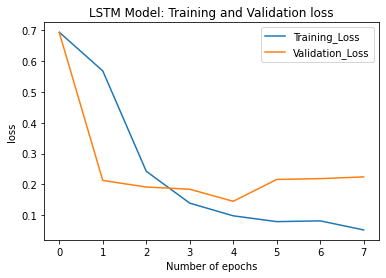

In [231]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

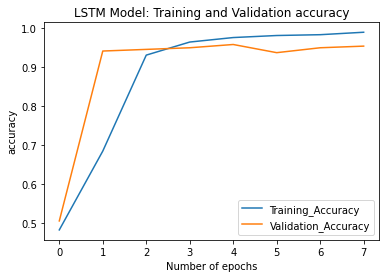

In [232]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [233]:
# # Biderectional LSTM Spam detection architecture
# model2 = Sequential()
# model2.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
# model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
# model2.add(Dense(1, activation='sigmoid'))
# model2.add(Flatten())
def bi_lstm():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(vocab_size,embedding_dim,input_length=max_len)(inputs)
  layer = Bidirectional(LSTM(64))(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.2)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

model2 = bi_lstm()
model2.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 50)]              0         
                                                                 
 embedding_28 (Embedding)    (None, 50, 32)            48000     
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 activation_43 (Activation)  (None, 256)               0         
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                          

In [163]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [166]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', min_delta= 0.0001, patience=3)
history2 = model2.fit(training_padded, train_labels,epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 4s - loss: 0.0202 - accuracy: 0.9941 - val_loss: 0.2297 - val_accuracy: 0.9565 - 4s/epoch - 94ms/step
Epoch 2/30
38/38 - 2s - loss: 0.0184 - accuracy: 0.9950 - val_loss: 0.1203 - val_accuracy: 0.9632 - 2s/epoch - 54ms/step
Epoch 3/30
38/38 - 2s - loss: 0.0149 - accuracy: 0.9958 - val_loss: 0.1237 - val_accuracy: 0.9632 - 2s/epoch - 52ms/step
Epoch 4/30
38/38 - 2s - loss: 0.0108 - accuracy: 0.9975 - val_loss: 0.1437 - val_accuracy: 0.9632 - 2s/epoch - 51ms/step
Epoch 5/30
38/38 - 2s - loss: 0.0098 - accuracy: 0.9983 - val_loss: 0.1363 - val_accuracy: 0.9666 - 2s/epoch - 51ms/step


In [167]:
model2.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 13ms/step - loss: 0.1363 - accuracy: 0.9666


[0.13628415763378143, 0.9665551781654358]

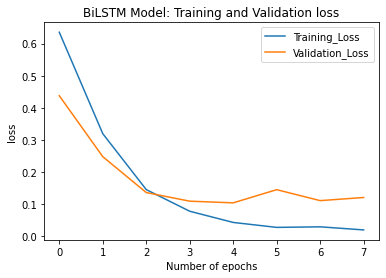

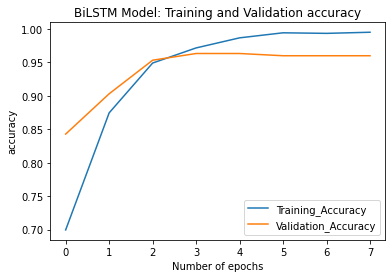

In [158]:
# Create a dataframe
metrics2 = pd.DataFrame(history2.history)

# Rename column
metrics2.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs2(var1, var2, string):
    metrics2[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs2('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs2('Training_Accuracy', 'Validation_Accuracy', 'accuracy')